# Statistical Arbitrage Strategy Based on the Markov Regime-Switching Model

## Introduction

This notebook demonstrates an implementation of the strategy described in [Bock, M. and Mestel, R. (2009). A regime-switching relative value arbitrage rule.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.453.3576&rep=rep1&type=pdf)

The traditional pairs trading strategy usually fails when fundamental or economic reasons cause a structural break on one of the stocks in the pair. This break will cause the temporary spread deviations formed by the pair to become persistent spread deviations which will not revert. Under these circumstances, betting on the spread to revert to its historical mean would imply a loss.

To overcome the problem of detecting whether the deviations are temporary or longer-lasting, this paper bridges the literature on Markov regime-switching and the scientific work on statistical arbitrage to develop useful trading rules for pairs trading.



---

## Assumptions

### Series Formed by the Trading Pair

It models the series $X_t$ formed by the trading pair as, 

$X_t = \mu_{s_t} + \epsilon_t$,

where 

$E[\epsilon_t] = 0$, $\sigma^2_{\epsilon_t} = \sigma^2_{s_t}$ and $s_t$ denotes the current regime.

### Markov Regime-Switching Model

A two-state, first-order Markov-switching process for $s_t$ is considered with the following transition probabilities:

$\Bigg\{ \begin{matrix}
prob[s_t = 1 | s_{t-1} = 1] = p \\
prob[s_t = 2 | s_{t-1} = 2] = q \\
\end{matrix}$ 

where
$1$ indicates a regime with a higher mean ($\mu_{1}$) while
$2$ indicates a regime with a lower mean ($\mu_{2}$).

### Strategy

The trading signal $z_t$ is determined in the following way:

$Case\ 1 \ \ current\ regime = 1$

$z_t = \left\{\begin{array}{l}
+1,\ if\ X_t \leq \mu_1 - \delta \cdot \sigma_1 \wedge P(s_t = 1 | X_t) \geq \rho \\
-1,\ if\ X_t \geq \mu_1 + \delta \cdot \sigma_1 \\ 
0,\ otherwise
\end{array}\right.$

$Case\ 2 \ \ current\ regime = 2$

$z_t = \left\{\begin{array}{l}
+1,\ if\ X_t \leq \mu_2 - \delta \cdot \sigma_2 \\
-1,\ if\ X_t \geq \mu_2 + \delta \cdot \sigma_2 \wedge P(s_t = 2 | X_t) \geq \rho\\ 
0,\ otherwise
\end{array}\right.$

where

$P(\cdot)$ denotes the smoothed probabilities for each state, 

$\delta$ and $\rho$ denote the standard deviation sensitivity parameter and the probability threshold of the trading strategy, respectively.

To be more specific, the trading signal can be described as,

$Case\ 1 \ \ current\ regime = 1$

$\left\{\begin{array}{l}
Open\ a\ long\ trade,\ if\ X_t \leq \mu_1 - \delta \cdot \sigma_1 \wedge P(s_t = 1 | X_t) \geq \rho \\
Close\ a\ long\ trade,\ if\ X_t \geq \mu_1 + \delta \cdot \sigma_1 \\ 
Open\ a\ short\ trade,\ if\ X_t \geq \mu_1 + \delta \cdot \sigma_1 \\
Close\ a\ short\ trade,\ if\ X_t \leq \mu_1 - \delta \cdot \sigma_1 \wedge P(s_t = 1 | X_t) \geq \rho \\
Do\ nothing,\ otherwise
\end{array}\right.$

$Case\ 2 \ \ current\ regime = 2$

$\left\{\begin{array}{l}
Open\ a\ long\ trade,\ if\ X_t \leq \mu_2 - \delta \cdot \sigma_2 \\
Close\ a\ long\ trade,\ if\ X_t \geq \mu_2 + \delta \cdot \sigma_2 \wedge P(s_t = 2 | X_t) \geq \rho\\ 
Open\ a\ short\ trade,\ if\ X_t \geq \mu_2 + \delta \cdot \sigma_2 \wedge P(s_t = 2 | X_t) \geq \rho\\ 
Close\ a\ short\ trade,\ if\ X_t \leq \mu_2 - \delta \cdot \sigma_2 \\
Do\ nothing,\ otherwise
\end{array}\right.$

---

## Steps to Execute the Strategy

### Step 1: Select a Trading Pair
In this paper, they used the DJ STOXX 600 component as the asset pool and applied the cointegration test for the pairs selection. One can use the same method as the paper did or other pairs selection algorithms like the distance approach for finding trading pairs.

### Step 2: Construct the Spread Series
In this paper, they used $\frac{P^A_t}{P^B_t}$ as the spread series. One can use the same method as the paper did or other formulae like $(P^A_t/P^A_0) - \beta \cdot (P^B_t/P^B_0)$ and $ln(P^A_t/P^A_0) - \beta \cdot ln(P^B_t/P^B_0)$ for constructing the spread series.

### Step 3: Estimate the Parameters of the Markov Regime-Switching Model 
Fit the Markov regime-switching model to the spread series with a rolling time window to estimate $
\mu_1$, $\mu_2$, $\sigma_1$, $\sigma_2$ and the current regime.

### Step 4: Determine the Signal of the Strategy
Determine the current signal based on the strategy and estimated parameters.

### Step 5: Decide the Trade
Decide the trade based on the signal at time $t$ and the position at time $t - 1$. Possible combinations are listed below:

$$Position_{t - 1}$$|$$Open\ a\ long\ trade$$|$$Close\ a\ long\ trade$$|$$Open\ a\ short\ trade$$|$$Close\ a\ short\ trade$$|$$Trade\ Action$$|$$Position_{t}$$
:---|:---|:---|:---|:---|:---|:---
0|True|False|False|X|$$Open\ a\ long\ trade$$|1
0|False|X|True|False|$$Open\ a\ short\ trade$$|-1
0|Otherwise||||$$Do\ nothing$$|0
+1|False|True|False|X|$$Close\ a\ long\ trade$$|0
+1|False|X|True|False|$$Close\ a\ long\ trade\ and\ open\ a\ short\ trade$$|-1
+1|Otherwise||||$$Do\ nothing$$|+1
-1|False|X|False|True|$$Close\ a\ short\ trade$$|0
-1|True|False|False|X|$$Close\ a\ short\ trade\ and\ open\ a\ long\ trade$$|1
-1|Otherwise||||$$Do\ nothing$$|-1

where X denotes the don't-care term, the value of X could be either True or False.

---

## Example Usage of the Module

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
from arbitragelab.time_series_approach.regime_switching_arbitrage_rule import RegimeSwitchingArbitrageRule

plt.rcParams['figure.figsize'] = (24, 12)

In [4]:
# Loading data
data =  yf.download("CL=F NG=F", start="2015-01-01", end="2017-01-01")["Adj Close"]

# Constructing spread series
Ratt = data["NG=F"]/data["CL=F"]

# Creating a class instance for getting the positions
RSAR = RegimeSwitchingArbitrageRule(delta = 1.5, rho = 0.6)

# Setting window size
window_size = 60

[*********************100%***********************]  2 of 2 completed


In [7]:
%%time
# Getting current signal
signal = RSAR.get_signal(Ratt[-window_size:], switching_variance = False, silence_warnings = True)
print("Open a long trade:", signal[0]) 
print("Close a long trade:", signal[1]) 
print("Open a short trade:", signal[2]) 
print("Close a short trade:", signal[3])

Open a long trade: False
Close a long trade: True
Open a short trade: True
Close a short trade: False
Wall time: 79.8 ms


In [11]:
%%time
# Getting signals on a rolling basis
signals = RSAR.get_signals(Ratt, window_size, switching_variance = True, silence_warnings = True)
print(signals.shape)

(503, 4)
Wall time: 46.8 s


In [13]:
%%time
# Deciding the trades based on the signals
trades = RSAR.get_trades(signals)
print(trades.shape)

(503, 4)
Wall time: 11 ms


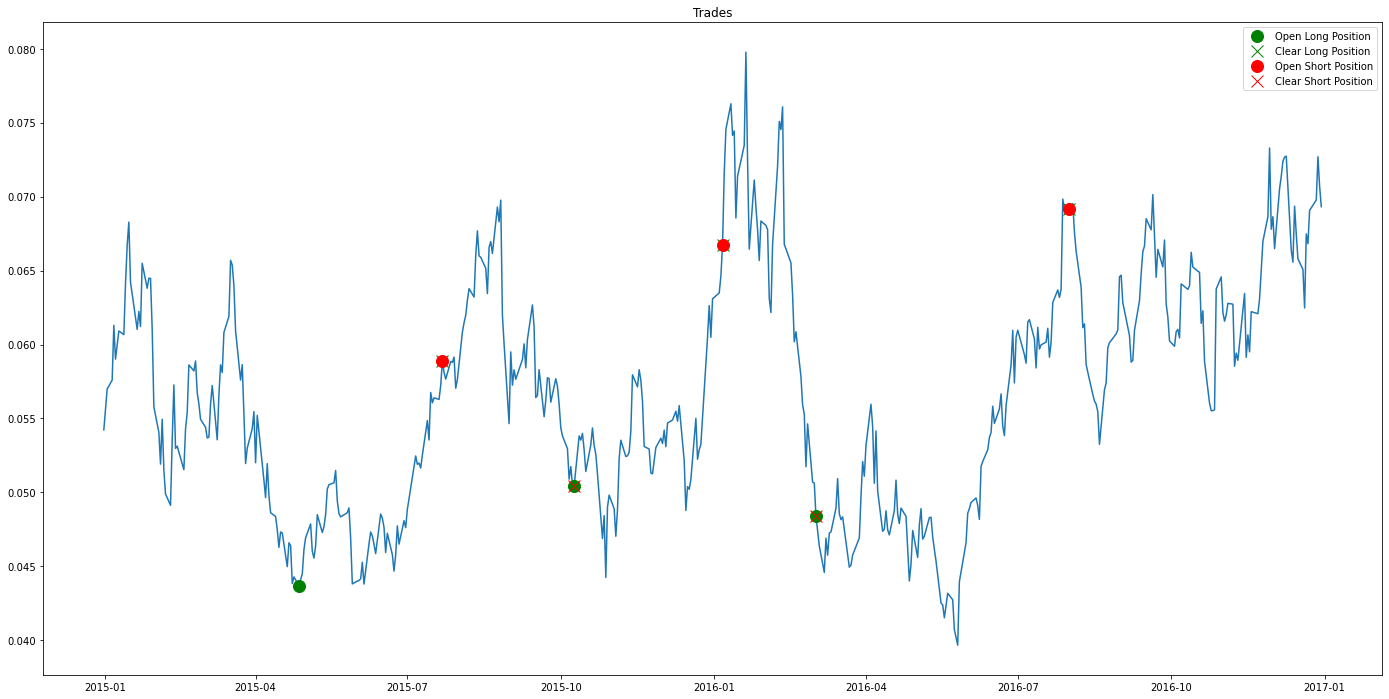

In [14]:
# Plotting trades
fig = RSAR.plot_trades(Ratt, trades)
plt.show()

---

## Custom Strategy

If the user is not satisfied with the default trading strategy described in the paper, one can use <code>`RegimeSwitchingArbitrageRule.change_strategy`</code> to modify it.

### Example

$Case\ 1 \ \ current\ regime = 1$

$\left\{\begin{array}{l}
Open\ a\ long\ trade,\ if\ X_t \leq \mu_1 - \delta \cdot \sigma_1\\
Close\ a\ long\ trade,\ if\ X_t \geq \mu_1\\ 
Open\ a\ short\ trade,\ if\ X_t \geq \mu_1 + \delta \cdot \sigma_1 \\
Close\ a\ short\ trade,\ if\ X_t \leq \mu_1\\
Do\ nothing,\ otherwise
\end{array}\right.$

$Case\ 2 \ \ current\ regime = 2$

$\left\{\begin{array}{l}
Open\ a\ long\ trade,\ if\ X_t \leq \mu_2 - \delta \cdot \sigma_2 \wedge P(s_t = 2 | X_t) \geq 0.7\\
Close\ a\ long\ trade,\ if\ X_t \geq \mu_2\\ 
Open\ a\ short\ trade,\ if\ X_t \geq \mu_2 + \delta \cdot \sigma_2 \wedge P(s_t = 2 | X_t) \geq \rho\\ 
Close\ a\ short\ trade,\ if\ X_t \leq \mu_2\\
Do\ nothing,\ otherwise
\end{array}\right.$

In [15]:
# Creating a class instance for getting the positions
RSAR = RegimeSwitchingArbitrageRule(delta = 1.5, rho = 0.6)

# Setting window size
window_size = 60

In [17]:
# Changing rules in the high regime
ol_rule = lambda Xt, mu, delta, sigma: Xt <= mu - delta*sigma
cl_rule = lambda Xt, mu, delta, sigma: Xt >= mu
os_rule = lambda Xt, mu, delta, sigma: Xt >= mu + delta*sigma
cs_rule = lambda Xt, mu, delta, sigma: Xt <= mu

RSAR.change_strategy("High", "Long", "Open", ol_rule)
RSAR.change_strategy("High", "Long", "Close", cl_rule)
RSAR.change_strategy("High", "Short", "Open", os_rule)
RSAR.change_strategy("High", "Short", "Close", cs_rule)

# Changing rules in the low regime
ol_rule = lambda Xt, mu, delta, sigma, prob: Xt <= mu - delta*sigma and prob >= 0.7
cl_rule = lambda Xt, mu, delta, sigma: Xt >= mu
os_rule = lambda Xt, mu, delta, sigma, prob, rho: Xt >= mu + delta*sigma and prob >= rho
cs_rule = lambda Xt, mu, delta, sigma: Xt <= mu

RSAR.change_strategy("Low", "Long", "Open", ol_rule)
RSAR.change_strategy("Low", "Long", "Close", cl_rule)
RSAR.change_strategy("Low", "Short", "Open", os_rule)
RSAR.change_strategy("Low", "Short", "Close", cs_rule)

In [18]:
%%time
# Getting signals on a rolling basis
signals = RSAR.get_signals(Ratt, window_size, switching_variance = True, silence_warnings = True)

# Deciding the trades based on the signals
trades = RSAR.get_trades(signals)

Wall time: 47.1 s


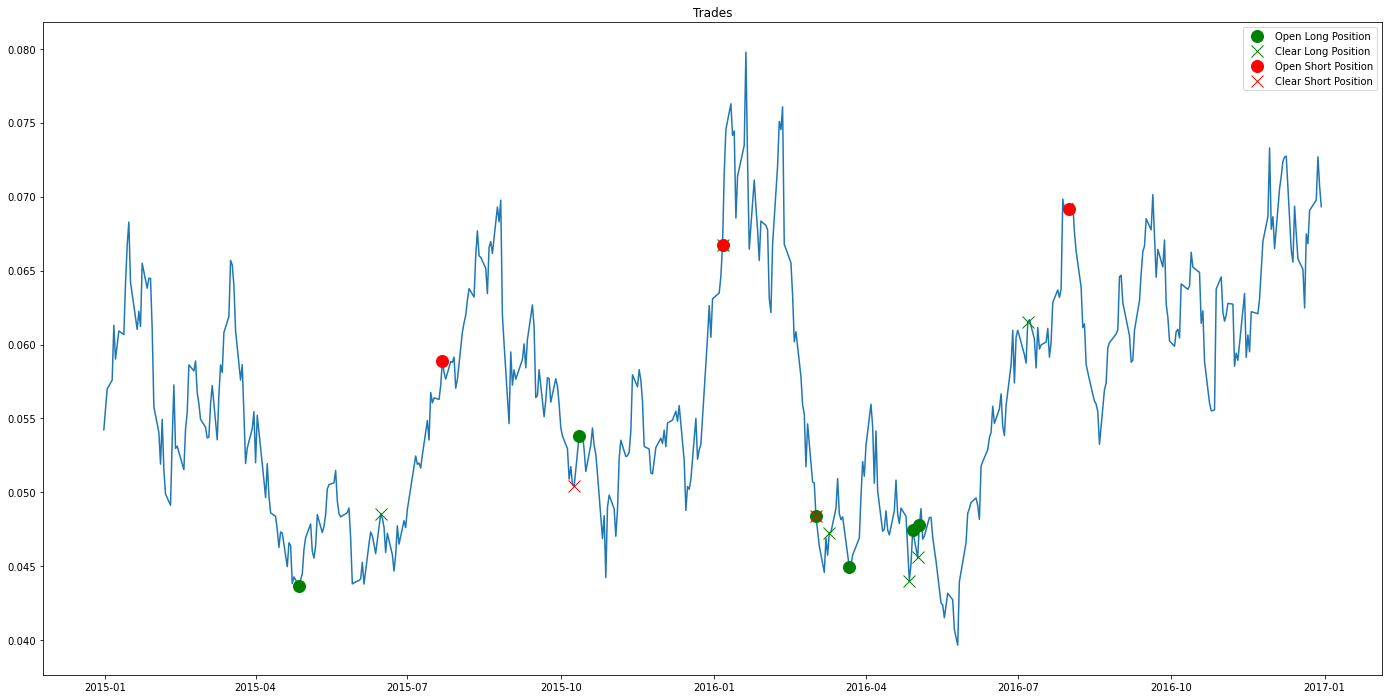

In [19]:
# Plotting trades
fig = RSAR.plot_trades(Ratt, trades)
plt.show()

## Conclusion

This notebook demonstrated a statistical arbitrage strategy based on the Markov regime-switching model, which is very different from the traditional one.

Key takeaways from the notebook:
- A new way to construct statistical arbitrage strategies.
- A way to detect structural break on the spread formed by the pair.

## References

1. [A regime-switching relative value arbitrage rule. Bock, M. and Mestel, R. (2009).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.453.3576&rep=rep1&type=pdf)